In [ ]:
import os, base64
from dotenv import load_dotenv, find_dotenv
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

c:\Users\kevin\miniconda3\envs\agents_mcp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### State

In [2]:
class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

#### Initialize Models

In [3]:
# Load the .env file
load_dotenv(find_dotenv())

# Retrieve HF_TOKEN from the environment variables
hf_token = os.getenv("HF_TOKEN")

In [ ]:
OLLAMA_MULTIMODAL_MODEL = "gemma3:4b"
HUGGINGFACE_LLM_TOOL_CALLING = "openai/gpt-oss-20b"

vision_llm = ChatOllama(model=OLLAMA_MULTIMODAL_MODEL)
llm = ChatHuggingFace(llm = HuggingFaceEndpoint(model=HUGGINGFACE_LLM_TOOL_CALLING, temperature=0.0,
                                                max_new_tokens=5000, huggingfacehub_api_token=hf_token,
                                                provider="auto"))

#### Tools

In [5]:
def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()

    except Exception as e:
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

def divide(a: int, b: int) -> float:
    """Divide a and b - for occasional calculations."""
    return a / b

In [6]:
# List of tools
tools = [
    divide,
    extract_text
]

In [7]:
llm_with_tools = llm.bind_tools(tools)

#### Nodes

In [8]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
        extract_text(img_path: str) -> str:
            Extract text from an image file using a multimodal model.

            Args:
                img_path: A local image file path (strings).

            Returns:
                A single string containing the concatenated text extracted from each image.
        
        divide(a: int, b: int) -> float:
            Divide a and b
    """
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are a helpful assitant that can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

#### State Graph

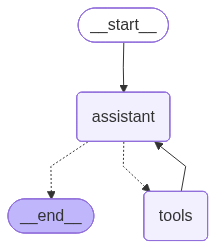

In [9]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
react_graph

#### Run Graph

In [10]:
# Example 1: Simple Calculations

messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_oaoM1c7kryauSMABTnXySYQo)
 Call ID: call_oaoM1c7kryauSMABTnXySYQo
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

6790 ÷ 5 = **1358**.


In [11]:
# Example 2: Analyze Document

messages = [HumanMessage(content="According to the abstract in the provided images. What's this research about?")]
messages = react_graph.invoke({"messages": messages, "input_file": "data/fake_news_detection_paper_abstract.png"})

# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the abstract in the provided images. What's this research about?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_ghRN4jgkfn6a5QMe3RGQUepM)
 Call ID: call_ghRN4jgkfn6a5QMe3RGQUepM
  Args:
    img_path: data/fake_news_detection_paper_abstract.png
================================= Tool Message =================================
Name: extract_text

It is fundamentally the same problem tackled for the English language; however, there is not a significant amount of publicly available and adequately labeled fake news in Spanish to effectively train a Machine Learning model, similarly to those proposed for the English language. Therefore, this work explores different training strategies and architectures to establish a baseline for further research in this area. Four datasets were used, two in Spanish and four experimental schemes were 